In [108]:
import pandas as pd
from pysam import VariantFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.style.use('ggplot')

# Reduce number of samples using stratified sampling

In [4]:
samples = pd.read_csv('/project/haplotyping/nico/analysis/genoml/1000genomes_phase3.tsv', sep='\t')
vcf = VariantFile('/project/haplotyping/nico/analysis/genoml/vcf/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')

In [5]:
samples = samples[samples['Sample name'].isin(list(vcf.header.samples))]
samples['Superpopulation code'].value_counts()

AFR    666
EUR    517
EAS    508
SAS    492
AMR    347
Name: Superpopulation code, dtype: int64

In [9]:
samples_subset = samples.groupby('Superpopulation code').apply(lambda x: x.sample(n=20))
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.to_csv('samples_subset.tsv', sep='\t', index=False)
num_samples = len(samples_subset)

In [7]:
vcf.subset_samples(list(samples_subset['Sample name']))

# Compute Hamming Distance between subset of samples

In [7]:
num_mismatches = np.zeros((num_samples, num_samples))
num_snps = 0

In [9]:
for rec in vcf.fetch():
    all_homref = True
    tmp_mismatches = np.zeros((num_samples, num_samples))
    for i in range(num_samples):
        if rec.samples[i]['GT'] != (0,0):
            all_homref = False
        for j in range(i, num_samples):
            if (rec.samples[i]['GT'] != rec.samples[j]['GT']) & (rec.samples[i]['GT'] != rec.samples[j]['GT'][::-1]):
                tmp_mismatches[i,j] += 1
    if not all_homref:
        num_mismatches += tmp_mismatches
        num_snps += 1

In [10]:
ham_dist = num_mismatches / num_snps
ham_dist = np.triu(ham_dist) + np.tril(ham_dist.T) # Make matrix balanced
np.savetxt('ham_dist.txt', ham_dist, delimiter='\t', fmt='%1.3f')

# Load pre-computed files

In [65]:
vcf = VariantFile('/project/haplotyping/nico/analysis/genoml/vcf/ALL.chr1.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf.gz')
samples_subset = pd.read_csv('MY_samples_subset.tsv', sep='\t')
ham_dist = np.loadtxt('ham_dist.txt')

In [66]:
vcf.subset_samples(list(samples_subset['Sample name']))

In [67]:
sorterIndex = dict(zip(list(vcf.header.samples), range(len(list(vcf.header.samples)))))
samples_subset['Rank'] = samples_subset['Sample name'].map(sorterIndex)
samples_subset.sort_values('Rank', inplace=True)
samples_subset.drop('Rank', axis=1, inplace=True)

In [68]:
df = pd.DataFrame(ham_dist)

In [73]:
df[['sample', 'superpop', 'pop']] = samples_subset[['Sample name', 'Superpopulation code', 'Population code']].reset_index(drop=True)

In [77]:
df = df.rename(columns=dict(zip(range(100), list(samples_subset['Sample name']))))
df = df.set_index('sample')

In [78]:
df

,HG00109,HG00129,HG00271,HG00290,HG00342,HG00378,HG00384,HG00404,HG00766,HG01063,...,NA20852,NA20881,NA20884,NA21102,NA21108,NA21120,NA21127,NA21128,superpop,pop
sample,,,,,,,,,,,,,,,,,,,,,
HG00109,0.000,0.148,0.154,0.155,0.152,0.154,0.153,0.169,0.168,0.189,...,0.160,0.161,0.161,0.159,0.162,0.161,0.160,0.161,EUR,GBR
HG00129,0.148,0.000,0.152,0.149,0.152,0.151,0.151,0.167,0.167,0.188,...,0.157,0.159,0.157,0.160,0.156,0.162,0.158,0.159,EUR,GBR
HG00271,0.154,0.152,0.000,0.148,0.153,0.149,0.154,0.164,0.166,0.189,...,0.159,0.163,0.161,0.160,0.161,0.160,0.162,0.160,EUR,FIN
HG00290,0.155,0.149,0.148,0.000,0.151,0.149,0.154,0.165,0.166,0.187,...,0.159,0.161,0.161,0.160,0.162,0.160,0.159,0.160,EUR,FIN
HG00342,0.152,0.152,0.153,0.151,0.000,0.153,0.152,0.167,0.166,0.189,...,0.159,0.159,0.161,0.164,0.162,0.165,0.160,0.162,EUR,FIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21102,0.159,0.160,0.160,0.160,0.164,0.165,0.161,0.165,0.167,0.191,...,0.161,0.159,0.157,0.000,0.159,0.158,0.159,0.159,SAS,GIH
NA21108,0.162,0.156,0.161,0.162,0.162,0.160,0.160,0.166,0.163,0.191,...,0.159,0.159,0.158,0.159,0.000,0.159,0.157,0.160,SAS,GIH
NA21120,0.161,0.162,0.160,0.160,0.165,0.165,0.163,0.166,0.168,0.190,...,0.158,0.157,0.156,0.158,0.159,0.000,0.159,0.158,SAS,GIH


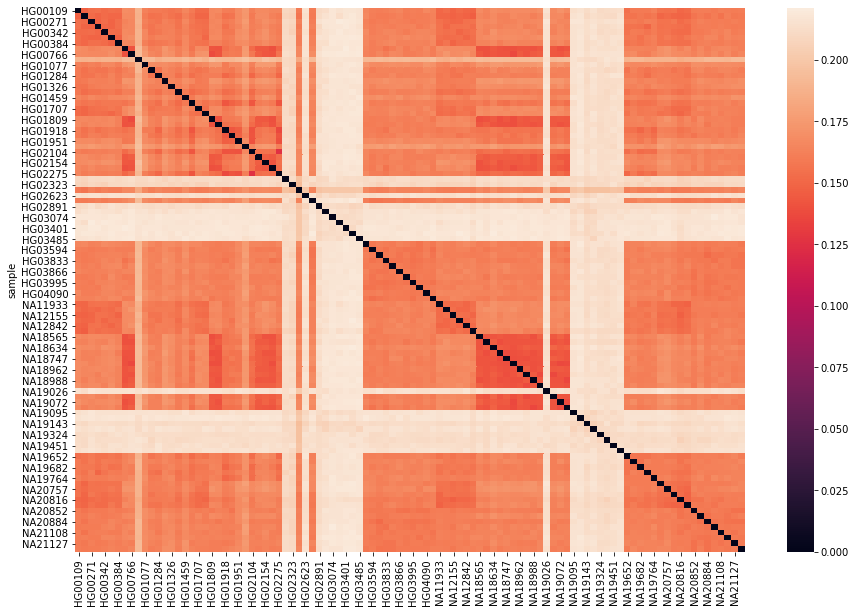

In [80]:
plt.figure(figsize=(15,10))
sns.heatmap(df.drop(['superpop', 'pop'], axis=1))
plt.show()

In [83]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df.drop(['superpop', 'pop'], axis=1))

In [93]:
df['superpop'].reset_index(drop=True)

0     EUR
1     EUR
2     EUR
3     EUR
4     EUR
     ... 
95    SAS
96    SAS
97    SAS
98    SAS
99    SAS
Name: superpop, Length: 100, dtype: object

In [102]:
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])
df_pca[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

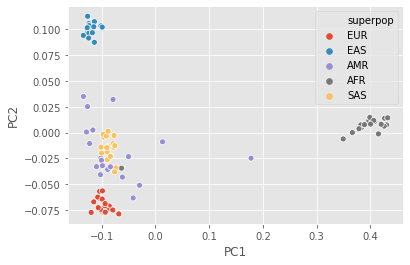

In [107]:
#plt.figure(figsize=(12,7))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='superpop')

In [109]:
tsne = TSNE(n_components=2)

In [110]:
transformed = tsne.fit_transform(df.drop(['superpop', 'pop'], axis=1))

In [112]:
df_tsne = pd.DataFrame(transformed, columns=['C1', 'C2'])
df_tsne[['superpop', 'pop']] = df[['superpop', 'pop']].reset_index(drop=True)

<AxesSubplot:xlabel='C1', ylabel='C2'>

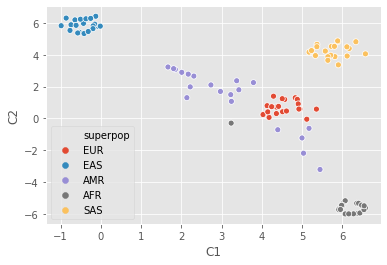

In [113]:
sns.scatterplot(x='C1', y='C2', data=df_tsne, hue='superpop')